<a href="https://colab.research.google.com/github/shuvayanb/LFF-for-design-and-optimisation/blob/main/LFF_Scramjet_intake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">LFF: Scramjet intake</font>

This Jupyter Notebook is the working demonstration of how simple gas-dynamic relations can be cast into a low-fiedlity framework for the design of scramjet intakes. The framework is an adoption of LFF approach by [reference](https://aip.scitation.org/doi/10.1063/1.4748130) and suitably alters it to account for favourable properties. The framework has been validation with existing literature [validation_1](https://aip.scitation.org/doi/10.1063/5.0006408) & [validation_2](https://www.researchgate.net/publication/349236917_Parametric_investigation_towards_the_design_of_a_scramjet_intake_using_low-fidelity_approach).  

Considering that this LLF approach is based on gas-dynamic relations, the viscous effects are not considered. Nevertheless, this framework has been evaluated with solutions from 2D Euler computations and has been found to be accurate. 

The purpose of this Notebook is to briefly demonstrate the featurs of the LFF approach and also to get an hands-on experience. 

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/scramjet_layout.png)

The LFF approach aims to design a mixed (external/internal) compression-based scramjet intake in hypersonic flows. It considers a scramjet intake with *n* external shocks and *m* internal shocks, with intake length *L* and heigth *H*, as shown in Fig. above. Simple gas dynamic relations are used to evaluate pre-post shock conditions such as:

$$\beta = \sin^{-1} \Bigg ( \sqrt{\frac{\Big ((SPR-1)(\frac{\gamma + 1}{2\gamma})\Big ) + 1)}{M^2_1}} \Bigg )$$

$$ \mathrm{   \theta} =  \mathrm{tan^{-1}} \Bigg ( 2 \ \mathrm{cot} \beta \Bigg( \frac{M_1^2 \ \mathrm{sin^2}\beta-1}{M_1^2 \ (\gamma + \mathrm{cos}2\beta)+2} \Bigg ) \Bigg ) $$

$$ M_2 =  \frac{1}{\mathrm{sin}(\beta-\theta)} \sqrt{\frac{1+\frac{\gamma-1}{2}M_1^2 \ \mathrm{sin}^2 \beta}{\gamma M_1^2 \ \mathrm{sin}^2 \beta -\frac{\gamma-1}{2}} } $$

$$ P_2 =  P_1 \Bigg( 1 + \frac{2\gamma}{\gamma+1} (M_1^2 \ \mathrm{sin}^2\beta-1) \Bigg)  $$ 

$$ \rho_2 =  \rho_1 \frac{(\gamma+1)M_1^2 \ \mathrm{sin}^2\beta}{(\gamma-1)M_1^2 \ \mathrm{sin}^2\beta+2} $$

where, $\beta$ and $\theta$ are the shock-wave and flow-deflection angle whereas $M, P, \rho$ are the Mach number, static pressure and density, respectively. Also, 1 and 2 refer to pre and post shock conditions. 

Using this framework, we study the following quantities of interest:

$$ \mathrm{\ Static \ pressure \ ratio, \ SPR_i} = \frac{P_2}{P_1} \$$

$$ \mathrm{ TPR_i} =  \frac{P_{02}}{P_2} \frac{P_{2}}{P_1} \frac{P_{1}}{P_{01}} $$

$$ \mathrm{Total \ pressure \ ratio, TPR} =  \prod_{i = 1}^{n+m} \mathrm{TPR_i}  \\ $$

$$ \mathrm{Distortion \ index, DI} =  \frac{\mathrm{max}\ (\frac{P}{P_{\infty}})}{\mathrm{min} \ (\frac{P}{P_{\infty}})} $$

$$ \mathrm{Spillage} = 1-A_1/H $$

where, $A_1$ is the intake area. Additionally, ICR is the internal contraction ratio and OCR is the overall contraction ratio. The overall LFF approach is described in the schematic below. 

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/framework_LFF.png)

Let's finally start with the framework by importing essential libraries

In [2]:
import numpy as np
import math

We will then provide some freestream conditions for the intake. Go ahead and change the existing ones as long as you are in the hypersonic regime. Note that since this is an iterative scheme, we need to provide some low tolerance limit for errors. Also, since the SPR is varied in this loop, we will have to provide an intial guess to $\texttt{SPR_guess}$ as well. 

In [3]:
M1 = 8           # Freestream Mach number
Me = 0.75*M1      # Mach number after last external shock
#Mis = 0.5*M1   # Mach number at the start of the isolator
P1 = 6079.5      # Freestream Pressure
T1 = 230.0       # Freestream Temperature
R = 287.0 
rho1 = P1/(R*T1) # Freestream density
gamma_Y = 1.4;   # Ratio of specific heats

V1 = M1*np.sqrt(gamma_Y*R*T1); # Freestream velocity

H = 0.1          # Height of cowl lip
Lmax = 1.0       # Length of forebody

tol = 1e-03;
error = 100.0;

n = 3            # Number of external shocks
m = 2            # Number of internal shocks 

SPR_guess = 0.001 # Initial guess Static Pressure Ratio

beta = [0 for i in range(n+m+1)]
theta = [0 for i in range(n+m+1)]
gam = [0 for i in range(n+m+1)]
si = [0 for i in range(n+m+2)]
M = [0 for i in range(n+m+1)]
P = [0 for i in range(n+m+1)]
T = [0 for i in range(n+m+1)]
rho = [0 for i in range(n+m+1)]

M[0] = M1         # Freestream Mach number
P[0] = P1         # Freestream Pressure
T[0] = T1         # Freestream Temparature
rho[0] = rho1     # Freestream density    

beta[0] = None 
theta[0] = None
gam[0] = None
si[0] = None 

After initialisation is done, we will execute the iterative scheme described in Fig. above first for the external section until the difference between the calulcated Mach number and the cowl Mach number is lower than the tolerance value. Once this is achieved, the pre and post shock conditions for the external section of the scramjet intake are obtained. We will repeat similar evaluations for the internal sections (or internal shocks) until flow at the isolator becomes parallel to the freestream direction. This makes sure that the non-uniformity at the isolator is less. 

In [4]:
while(error>tol):

    for i in range(0, n, 1): #***************External Shocks*****************//

        beta[i+1] = math.asin( np.sqrt(( ((SPR_guess-1.0)*((gamma_Y+1)/(2*gamma_Y))) + 1)/(M[i]*M[i])))

        theta[i+1] = math.atan((2*np.cos(beta[i+1])*(M[i]*M[i]*np.sin(beta[i+1])*np.sin(beta[i+1])-1))/(np.sin(beta[i+1])*(M[i]*M[i]*(gamma_Y+np.cos(2*beta[i+1]))+2)))

        M[i+1] = ((np.sqrt((M[i]*M[i]*pow(np.sin(beta[i+1]),2)+(2/(gamma_Y-1)))/ (((2*gamma_Y*M[i]*M[i]*pow(np.sin(beta[i+1]),2)/(gamma_Y-1))-1)))) / np.sin(beta[i+1]-theta[i+1]))

        P[i+1] = (P[i] * (1 + ( ((2*gamma_Y)/(gamma_Y+1)) * (pow(M[i]*np.sin(beta[i+1]),2) -1)  )))

        rho[i+1] = rho[i] * ( ((gamma_Y+1)*M[i]*M[i]*np.sin(beta[i+1])*np.sin(beta[i+1])) / (((gamma_Y-1)*M[i]*M[i]*np.sin(beta[i+1])*np.sin(beta[i+1])) + 2)  )

        T[i+1] = T[i] * (P[i+1]/P[i]) * (rho[i]/rho[i+1])

        #gam[i+1] = beta[i+1] + theta[i+1]

        #si[i+1] = gam[i+1] - beta[i+1]


        if i==0:
            gam[i+1] = beta[i+1]
            si[i+1] = 0.0


        elif i>0:
            gam[i+1] = beta[i+1] + theta[i] + si[i]
            si[i+1] = gam[i+1] - beta[i+1]


    SPR_guess = SPR_guess + 0.001

    error = abs(Me-M[n])
    
sum_ext=0

for i in range(0, n, 1):

    sum_ext+=theta[i+1]


ext_guess_PR = SPR_guess - 0.001

error = 100.0

SPR_guess = 0.001

temp = 0.0


while(error>tol):

    for i in range(0, m, 1): #***************Internal Shocks*****************//
         
        beta[n+i+1] = math.asin( np.sqrt(( ((SPR_guess-1.0)*((gamma_Y+1)/(2*gamma_Y))) + 1)/(M[n+i]*M[n+i])))

        theta[n+i+1] = math.atan((2*np.cos(beta[n+i+1])*(M[n+i]*M[n+i]*np.sin(beta[n+i+1])*np.sin(beta[n+i+1])-1))/(np.sin(beta[n+i+1])*(M[n+i]*M[n+i]*(gamma_Y+np.cos(2*beta[n+i+1]))+2)))

        M[n+i+1] = (np.sqrt((M[n+i]*M[n+i]*pow(np.sin(beta[n+i+1]),2)+(2/(gamma_Y-1)))/ (((2*gamma_Y*M[n+i]*M[n+i]*pow(np.sin(beta[n+i+1]),2)/(gamma_Y-1))-1)))) / np.sin(beta[n+i+1]-theta[n+i+1] )

        P[n+i+1] = P[n+i] * (1 + ( ((2*gamma_Y)/(gamma_Y+1)) * (pow(M[n+i]*np.sin(beta[n+i+1]),2) -1)  ))

        rho[n+i+1] = rho[n+i] * (  ((gamma_Y+1)*M[n+i]*M[n+i]*np.sin(beta[n+i+1])*np.sin(beta[n+i+1])) / (((gamma_Y-1)*M[n+i]*M[n+i]*np.sin(beta[n+i+1])*np.sin(beta[n+i+1])) + 2)  )

        T[n+i+1] = T[n+i] * (P[n+i+1]/P[n+i]) * (rho[n+i]/rho[n+i+1])


    sum_int=0;

    for i in range(0, m, 1):
        sum_int+=theta[n+i+1]
    
    si[n+m+1] = 0

    for i in range(m, 0, -1):

        si[n+i] = si[n+i+1] + theta[n+i]
        gam[n+i] = beta[n+i] - si[n+i]
        
    

    SPR_guess = SPR_guess + 0.001

    error = abs(sum_ext-sum_int)

int_guess_PR = SPR_guess - 0.001;

#print([si[-1],gam[-1],M[-1],T[-1],P[-1]])
#print(si)
#print(gam)


We have now completed the crux of the computations. $i.e.,$ the pre and post shocks conditions for the entire scramjet intake are obtained such that all the external shocks emanating from the leading-edge hits the cowl edge ($\textit{i.e.,}$ shock-on-lip) and all the internal shocks enamating from the cowl hits the ramp shoulder ($\textit{i.e.,}$ shock-on-shoulder) condition. The first condition makes sure that the loss due to spillage is minimum whereas the latter ensures that the flow non-uniformity at the isolator is low. Now we will perform some trigonimetric computations to determine how the shocks form in relation to the sramjet configuration. 

In [5]:
#Scramjet shape
 
#***************** Trigonometric calculations ********************

import os

file_ex = "external_shocks.dat"

file_in = "internal_shocks.dat"

file_ramp = "ramp_geo.dat"


if os.path.exists(file_ex):
    os.remove(file_ex)
    
if os.path.exists(file_in):
    os.remove(file_in)
   
if os.path.exists(file_ramp):
    os.remove(file_ramp)
    

myfile_ex = open(file_ex, 'a')
myfile_in = open(file_in, 'a')
myfile_ramp = open(file_ramp, 'a')
              

X = [0 for i in range(n+m+1)]
Y = [0 for i in range(n+m+1)]

X[n+1] = 0
Y[n+1] = 0

y = 0.0;
x = 0.0;

X[0] = 0.0;
Y[0] = 0.0;


for i in range(1,n+1,i):

    if(i==1):
        j=i-1;


    elif(i!=1):
        j=i;


    while(y<=H):

        y = Y[j] + ( (x-X[j]) * np.tan(gam[i]) );
        x = x + 0.001;
        myfile_ex.write("%s %s\n" % (x,y))


    if(i==1):

        gg = x
        X[i] = gg

        gg = y
        Y[i] = gg
        

    x = X[j]

    if(i!=n):
        temp = ((Y[1]-Y[j]) - (X[1]*np.tan(gam[i+1])) + (X[j]*np.tan(si[i]+theta[i])) ) / (  np.tan(si[i]+theta[i]) - np.tan(gam[i+1]))
    

    else:  #because the shock changes to internal and hence gamma becomes negative  
        temp = ((Y[1]-Y[j]) - (X[1]*np.tan(-gam[i+1])) + (X[j]*np.tan(si[i]+theta[i])) ) / (  np.tan(si[i]+theta[i]) - np.tan(-gam[i+1]))


    while(x<=temp):

        y = Y[j] + ( (x-X[j])*(np.tan(theta[i]+si[i])));
        x = x + 0.001;
        myfile_ramp.write("%s %s\n" % (x,y))
        

    gg = x;
    X[i+1] = gg;

    gg = y;
    Y[i+1] = gg;


#print([temp,X[1],Y[1],X[2],Y[2],X[3],Y[3],X[4],Y[4],gam[1],gam[2],gam[3],gam[4],si[1],si[2],si[3],si[4],gg])

x = X[1]

while(x<=X[n+1]): # for the  first internal shock

    y = Y[n+1] + ( (x-X[n+1])*np.tan(-gam[n+1]) );

    x = x + 0.001;

    #File1<<x<<"  "<<y<<endl;
    myfile_in.write("%s %s\n" % (x,y))



for i in range(1,m,1):  # for the remaining internal shocks
   
    x=X[n+1];

    if(i==1): #because in the first case the cowl starts with (X[1],Y[1])
        temp = (Y[n+1] - Y[1] + X[1]*np.tan(si[n+i+1]) - X[n+1]*np.tan(-gam[n+i+1]))/(np.tan(si[n+i+1]) - np.tan(-gam[n+i+1]));

    else:
        temp = (Y[n+1] - Y[n+i] + X[n+i]*np.tan(si[n+i+1]) - X[n+1]*np.tan(-gam[n+i+1]))/(np.tan(si[n+i+1]) - np.tan(-gam[n+i+1]));


    while(x>=temp):

        y = Y[n+1] + ((x-X[n+1])*np.tan(-gam[n+i+1]))

        #File1<<x<<"  "<<y<<endl
        myfile_in.write("%s %s\n" % (x,y))

        x = x - 0.001;



    X[n+i+1] = x

    Y[n+i+1] = y

    if(i==1): #because in the first case the cowl starts with (X[1],Y[1])

        x = X[1]

        while(x<=X[n+i+1]):

            y = Y[1] + ((x-X[1])*np.tan(si[n+i+1]));
            myfile_ramp.write("%s %s\n" % (x,y))
            x = x + 0.001;

    else:
        x=X[n+i];

        while(x<=X[n+i+1]):

            y = Y[n+i] + ((x-X[n+i])*np.tan(si[n+i+1]));
            myfile_in.write("%s %s\n" % (x,y))
            x = x + 0.001;


X[n+m] = x

Y[n+m] = y

if(m==1):

    myfile_in.write("%s %s\n" % (Lmax,y))

    myfile_in.write("%s %s\n" % (Lmax,Y[1]))

    myfile_in.write("%s %s\n" % (X[1],Y[1]))

else: 

    myfile_ramp.write("%s %s\n" % (Lmax,y))

    myfile_ramp.write("%s %s\n" % (Lmax,Y[n+1]))

    myfile_ramp.write("%s %s\n" % (X[n+1],Y[n+1]))


myfile_in.close()
myfile_ex.close()
myfile_ramp.close()

The next module is meant for the estimation of the point of intersection of the normals dropped from the cowl onto the scramjet ramp. This aids in the calculation of cowl area, $A_c$. 

In [6]:
#phi_calc()
 
#*************************** Calculation for calculation of phi_x and phi_y points, which are normals dropped on to the ramp from cowl lip ****************************/////

filename2 = "2phi_points.dat"

if os.path.exists(filename2):
    os.remove(filename2)

myfile2 = open(filename2, 'a')



xo = X[1]    # coordinates of the Cowl lip
yo = Y[1]


x_1 = X[n]   # coordinates of the last ramp onto which the normal from the cowl lip is to be dropped
x_2 = X[n+1]
y_1 = Y[n]
y_2 = Y[n+1]

if(n==1):     # Exception 
    
    x_1 = X[0]
    x_2 = X[n+1]
    y_1 = Y[0]
    y_2 = Y[n+1]


t = (y_2-y_1)*(yo-y_1)+(x_2-x_1)*(xo-x_1)
t = t/(pow((y_2-y_1),2)+pow((x_2-x_1),2))

if((t<0)and(t>1)):
    if(t>1):
        t=1
    else:
        t=0


phi_x=x_1+t*(x_2-x_1) # Coordinates of the intersection of the normal dropped from cowl lip to the last ramp  
phi_y=y_1+t*(y_2-y_1) 


if(m==1):

    At = H-Y[n+1]

    Ac = sqrt(pow((X[1]-phi_x),2) + pow((Y[1]-phi_y),2) ) 

    Ai = H

    As = sqrt(pow((X[1]-X[n+1]),2) + pow((Y[1]-Y[n+1]),2) ) 


elif(m>=2):

    At = Y[n+m]-Y[n]

    Ac = np.sqrt(pow((X[1]-phi_x),2) + pow((Y[1]-phi_y),2) ) 

    Ai = Y[n+m]


At_Ai = (At/Ac)*(np.sin(beta[n]-theta[n])/ np.sin(beta[1]))

myfile2.write("%s %s\n" % (phi_x,phi_y))

myfile2.write("%s %s\n" % (X[1],Y[1]))

myfile2.close()



We will now get to see how the shocks form in relation to the scramjet intake configuration. 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


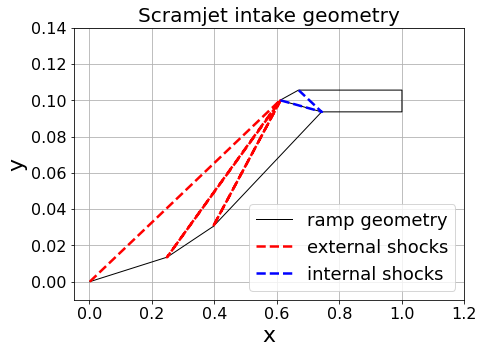

In [7]:
#plotting

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

import pylab
import numpy as np

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



fname = 'ramp_geo.dat'
ramp_data = np.loadtxt(fname, delimiter = " ", skiprows=0)

fname = 'external_shocks.dat'
ex_shocks = np.loadtxt(fname, delimiter = " ", skiprows=0)

fname = 'internal_shocks.dat'
in_shocks = np.loadtxt(fname, delimiter = " ", skiprows=0)

ramp_x = ramp_data[:,0]
ramp_y = ramp_data[:,1]

ex_shocks_x = ex_shocks[:,0]
ex_shocks_y = ex_shocks[:,1]

in_shocks_x = in_shocks[:,0]
in_shocks_y = in_shocks[:,1]

plt.figure(figsize=(7, 5))

plt.plot(ramp_x,ramp_y,'-k', linewidth=1.0,label='ramp geometry')
plt.plot(ex_shocks_x,ex_shocks_y,'--r', linewidth=2.5,label='external shocks')
plt.plot(in_shocks_x,in_shocks_y,'--b', linewidth=2.5,label='internal shocks')
plt.title('Scramjet intake geometry', fontsize = 20)    
plt.xlabel('x',fontsize=22)
plt.ylabel('y',fontsize=22)
plt.tick_params(labelsize=16)
plt.xlim(-0.05, 1.2)
plt.ylim(-0.01, 0.14)
plt.legend(loc="lower right")
plt.grid(True, which="both", ls="-")



We will now evaluate some constants that inform us of the area ratio. This steps is crucial from the point of view of unstart phenomenon of scrmajets. 

In [8]:
M_c = M[n]

temp1 = ((gamma_Y+1)*M_c*M_c)/(((gamma_Y-1)*M_c*M_c) + 2);
temp2 = pow(temp1,(gamma_Y/(gamma_Y-1)));
temp3 = temp2/M_c;
temp1 = (gamma_Y+1)/((2*gamma_Y*M_c*M_c)-(gamma_Y-1));
temp2 = pow(temp1,(1/(gamma_Y-1)));
temp1 = (2+((gamma_Y-1)*M_c*M_c))/(gamma_Y+1);
temp4 = pow(temp1,((gamma_Y+1)/(2*(gamma_Y-1))));

temp_Kl = temp3*temp2*temp4;


if(M_c>=1.65 and M_c<=4.68):

    temp_emp = 0.933 + (M_c/6.87) + ((M_c*M_c)/40.9) # Emperical correlation bgamma_Y Sun & Zhang, 2010 JPP

else:

    temp_emp = 0;



temp1 = (2/(gamma_Y+1))*(1+((gamma_Y-1)*0.5*M_c*M_c))
temp2 = pow(temp1,((gamma_Y+1)/(2*(gamma_Y-1))))

temp_iso = temp2/M_c # Isothermal limit

S = 0.6;

temp_molder = 1/ ((S/temp_Kl) + ((1-S)/temp_iso))


Finally, we will now evaluate the various quantities of interest such as TPR, SPR, OCR, ICR etc. 

In [9]:
#parameters

#***************** All Variables/Parameters  ********************//

filename3 = "2all_parameters.dat"

if os.path.exists(filename3):
    os.remove(filename3)

myfile3 = open(filename3, 'a')


TPR = [0 for i in range(n+m+1)]

# TPR, Total Pressure Recovery, as defined by Raj and Venkatasubbiah 2012, PoF : i.e. P02/P01 = (P02/P2)*(P2/P1)*(P1/P01)

# SPR, Static Pressure Ratio, as defined by Raj and Venkatasubbiah 2012, PoF : i.e. ratio of isolator static pressure to freestream static pressure, P2/P1
# SPR, is also same as Compression Ratio, as defined by Smart 2012, AIAA : 	 i.e. ratio of isolator static pressure to freestream static pressure, P2/P1

# KE_ad_1, Adiabatic Kinetic Energy, as defined by Waltrup et al. 1982, AGARD
# KE_ad_2, Adiabatic Kinetic Energy, as available in Smart 2012, AIAA

# OCR, Overall Contraction ratio, as defined in Veillard et al. 08, JPP : i.e. ratio of Ainf to Ath 
# ICR, Internal Contraction ratio, as defined in Veillard et al. 08, JPP : i.e. ratio of Acowl to Ath



for i in range(1,n+1,1):

    temp1 = 1 + ((gamma_Y-1)*0.5*pow(M[i],2))
    temp1 = pow(temp1,(gamma_Y/(gamma_Y-1)))

    temp2 = 1 + ((2*gamma_Y)/(gamma_Y+1))*(pow(M[i-1]*np.sin(beta[i]),2)-1)

    temp3 = 1 + ((gamma_Y-1)*0.5*pow(M[i-1],2))
    temp3 = pow(temp3,(-gamma_Y/(gamma_Y-1)))

    TPR[i] = temp1*temp2*temp3 # Total Pressure Ratio across a single shock


for i in range(n+1,n+m+1,1):
    temp1 = 1 + ((gamma_Y-1)*0.5*pow(M[i],2))
    temp1 = pow(temp1,(gamma_Y/(gamma_Y-1)))

    temp2 = 1 + ((2*gamma_Y)/(gamma_Y+1))*(pow(M[i-1]*np.sin(beta[i]),2)-1)

    temp3 = 1 + ((gamma_Y-1)*0.5*pow(M[i-1],2))
    temp3 = pow(temp3,(-gamma_Y/(gamma_Y-1)))

    TPR[i] = temp1*temp2*temp3 # Total Pressure Ratio across a single shock



TPR_tot=1.0;

for i in range(1,n+m+1,i):

    TPR_tot=TPR_tot*TPR[i]


TP_recovery = TPR_tot

SPR =  P[n+m]/P[0]

KE_ad_1 = 1-(0.4* (pow (1-(M[n+m]/M[0]),4))   )

KE_ad_2 = 1-((pow(9/M[0],0.7))*((0.018*(1-(M[n+m]/M[0])))+(0.12*(pow((1-(M[n+m]/M[0])),4)))))

eta_B = ((T[0]*(pow((P[n+m]/P[0]), (gamma_Y-1)/gamma_Y))) - T[0])/(T[n+m]-T[0]) # Compression as defined in ogawa and Boyce 2012, AIAA

OCR = Ai/At

#OCR = 1/At_Ai;

ICR = Ac/At;

#printf("\n \n ***Area ratio:***\n \n At/Ai = %Le \n At/Ac = %Le \n  \n ***Pressure ratio:***\n\n SPR = %Le \n TP_recovery  = %Le  \n \n ***Kinetic Energy:***\n \n KE_ad_waltrup = %Le \n KE_ad_2 = %Le \n \n ***Mach number:***\n \n Minf = %Le \n M_cowl = %Le \n \n ***Isolator properties:***\n \n M_is = %Le \n T_is = %Le \n P_is = %Le \n Rho_is = %Le \n \n ***Drag coefficient:***\n \n Exact Drag is %Le \n Newtonian Drag is %Le\n Compression Efficidncy is %Le \n \n ",);
print([1/OCR,1/ICR,SPR,TP_recovery,KE_ad_1*100,KE_ad_2*100,M1,M[n],M[n+m],T[n+m],P[n+m],rho[n+m],eta_B])

#printf("\n TPR %Le  %Le  %Le  %Le\n",P[n+m],M[n+m],P1,M1);
print('\n Exit pressure, Mach number and freestream pressure and Mach number are {}\n'.format([P[n+m],M[n+m],P1,M1]))

#outfile <<TP_recovery <<"  "<<SPR<<"  "<<KE_ad_1*100<<"  "<<KE_ad_2*100<<"  "<<OCR<<"  "<<ICR<<endl;	

#outfile <<M1<<"  "<<TP_recovery<<"  "<<SPR<<"  "<<T[n+m]<<endl;

#outfile <<M1<<"  "<<theta[1]*180/3.14159<<"  "<<theta[2]*180/3.14159<<"  "<<theta[3]*180/3.14159<<"  "<<theta[4]*180/3.14159<<"  "<<theta[5]*180/3.14159<<"  "<<theta[6]*180/3.14159<<endl;

myfile3.write("%s \n" % (M1))
#outfile <<M1<<endl;
myfile3.write("%s \n" % (Me))
#outfile <<Me<<endl;
myfile3.write("%s \n" % (At))
#outfile <<At<<endl;
myfile3.write("%s \n" % (Ac))
#outfile <<Ac<<endl;
myfile3.write("%s \n" % (TP_recovery))
#outfile <<TP_recovery<<endl;
myfile3.write("%s \n" % (SPR))
#outfile <<SPR<<endl;
myfile3.write("%s \n" % (KE_ad_2))
#outfile <<KE_ad_2*100<<endl;
myfile3.write("%s \n" % (eta_B))
#outfile <<eta_B<<endl;

if(M[n]>=1.65 and M[n]<=4.68):

    if(1/ICR<1/temp_emp):
    
        #printf("\n Compression below Emperical limit of Sun and Zhang! %Le  %Le\n", 1/ICR,1/temp_emp);
        print('\n Compression below Emperical limit of Sun and Zhang! {}'.format([1/ICR,1/temp_emp]))
    

    if(1/ICR<1/temp_molder):
    
        #printf("\n Compression below Molder limit!  %Le  %Le\n", 1/ICR,1/temp_molder);
        print('Compression below Molder limit!  {}'.format([1/ICR,1/temp_molder]))
    


    if(1/ICR>1/temp_Kl):
    
        #printf("\n Compression over Kantrowitz limit! {}", 1/ICR,1/temp_Kl);
        print('\n Compression over Kantrowitz limit!  {}'.format(1/ICR,1/temp_Kl))
    

#printf("\n Compression!  %Le  %Le\n", ICR,temp_Kl);
print('\n Compression!  {}\n'.format(ICR,temp_Kl))




[0.7139406875199386, 2.508589108697148, 22.58095528444117, 0.9797717623325702, 98.87715854152472, 98.83409839010635, 8, 6.000526022457342, 4.725427584523466, 580.6876704342092, 137280.9176517601, 0.8237314960857095, 0.9421975607216336]

 Exit pressure, Mach number and freestream pressure and Mach number are [137280.9176517601, 4.725427584523466, 6079.5, 8]


 Compression!  0.39863044790119356

